In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import maxabs_scale


from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from scipy.sparse import csr_matrix
from scipy.sparse import hstack

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
print(train.shape, test.shape)

(7613, 5) (3263, 4)


In [4]:
combined_data = pd.concat([train.drop(['target', 'id'] , axis=1), test.drop(['id'] , axis=1)], ignore_index=True)

In [5]:
def pre_process_text(df):

    # Remove URLs
    url_pattern = r'http\S+|www.\S+'
    df = df.str.replace(url_pattern, '', regex=True)

    # Remoove mention pattern
    mention_pattern = r'@\w+'
    df = df.str.replace(mention_pattern, '', regex=True)

    #Remove Emoticons
    emoticons_pattern = re.compile("["
                     u"\U0001F600-\U0001F64F"  # emoticons
                     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                     u"\U0001F680-\U0001F6FF"  # transport & map symbols
                     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     "]+", flags=re.UNICODE)
    
    df= df.str.replace(emoticons_pattern, '')

    # Remove special chars
    df = df.str.replace(r'[^\w\s]', '', regex = True)

    # To Lower case
    df = df.str.lower()

    # Tokenize & remove stopwords
    stop_words = set(stopwords.words('english'))
    df =df.apply(lambda x : ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

    return df

In [6]:
combined_data['text_new'] = pre_process_text(combined_data.text)


In [7]:

combined_data.keyword = combined_data.keyword.str.replace('%20', ' ')

In [8]:
(combined_data.isnull().sum()/combined_data.shape[0])*100

keyword      0.799926
location    33.449798
text         0.000000
text_new     0.000000
dtype: float64

In [9]:
null_cols = combined_data.columns[combined_data.isnull().any()]

In [10]:
combined_data[null_cols] = combined_data[null_cols].fillna('missing')

In [11]:
keywords = pd.get_dummies(combined_data['keyword'], drop_first=True)

In [12]:
keywords = csr_matrix(keywords.astype(pd.SparseDtype("float64",0)).sparse.to_coo())

In [13]:
keywords.shape

(10876, 221)

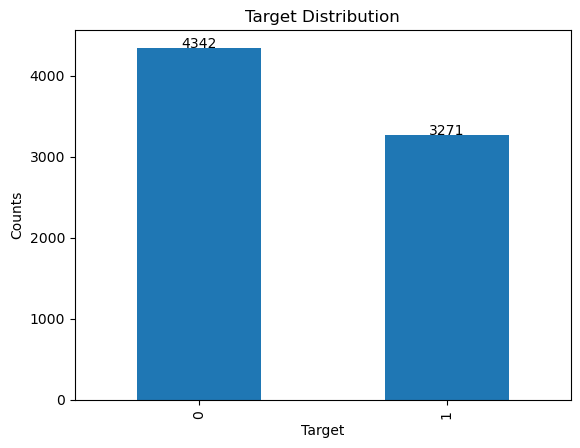

In [14]:
train.target.value_counts().plot.bar()
mpl.pyplot.xlabel("Target")
mpl.pyplot.ylabel("Counts")
mpl.pyplot.title("Target Distribution")

for i, v in enumerate(train.target.value_counts().values):
    mpl.pyplot.text(i, v, str(v), ha='center', va = 'baseline')

In [15]:
#TFIDF

vectorizer = TfidfVectorizer(ngram_range=(2,3))

vectorizer.fit(combined_data.text_new)

X= vectorizer.transform(combined_data.text_new)

y_train = train.target

In [16]:
vectorizer.get_feature_names_out().shape

(122627,)

In [17]:
y_train.shape

(7613,)

In [18]:
#X = csr_matrix(hstack([X,keywords]))

In [19]:
maxabs_scale(X,copy=False)

<10876x122627 sparse matrix of type '<class 'numpy.float64'>'
	with 162230 stored elements in Compressed Sparse Row format>

In [20]:
X_train = X[:7613,]

In [21]:
X_train.shape

(7613, 122627)

In [22]:
X_test = X[7613:,]

In [ ]:
#svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

#svd.fit(X_train)

#X_train = svd.transform(X_train)

#X_test = svd.transform(X_test)

# MLPClassifier

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000 , solver='lbfgs').fit(X_train, y_train)

In [ ]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
print(classification_report(y_train, predict_train))

In [ ]:
submission = pd.DataFrame(test['id'] , columns=['id'])

In [ ]:
submission['target'] = predict_test

In [ ]:
submission.to_csv('submission.csv' , index=False)

# Multinomial Naive Bayes Classifier

In [23]:
clf = MultinomialNB()

param_grid = {'alpha': [0.01, 0.1,0.5,0.8, 1, 10]}

grid = GridSearchCV(clf, param_grid, cv=5)

grid.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 0.8, 1, 10]})

In [24]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 10}
0.6213109025602177


In [25]:
clf = MultinomialNB(alpha=10).fit(X_train,y_train)

In [26]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [27]:
print(classification_report(y_train, predict_train))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4342
           1       0.99      0.94      0.97      3271

    accuracy                           0.97      7613
   macro avg       0.97      0.97      0.97      7613
weighted avg       0.97      0.97      0.97      7613



In [28]:
submission = pd.DataFrame(test['id'] , columns=['id'])
submission['target'] = predict_test
submission.to_csv('submission.csv' , index=False)

# LogisticRegression

In [36]:
clf = LogisticRegression(random_state=42, solver= 'liblinear' , class_weight = 'balanced', max_iter=10000
                            ).fit(X_train, y_train)

In [37]:
grid_values = {'penalty' : ['l1', 'l2'] ,'C':[0.001,0.009,0.01,.09,1]}

grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')

grid_clf_acc.fit(X_train, y_train)

/home/sunny/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1],
                         'penalty': ['l1', 'l2']},
             scoring='recall')